In [1]:
import csv 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd
import json

In [2]:
debug_path = "results_ordinal/full.csv"

with open(debug_path) as f1:
    reader = csv.DictReader(f1)
    data = [x for x in reader]

print(data[0].keys())


dict_keys(['HITId', 'HITTypeId', 'Title', 'Description', 'Keywords', 'Reward', 'CreationTime', 'MaxAssignments', 'RequesterAnnotation', 'AssignmentDurationInSeconds', 'AutoApprovalDelayInSeconds', 'Expiration', 'NumberOfSimilarHITs', 'LifetimeInSeconds', 'AssignmentId', 'WorkerId', 'AssignmentStatus', 'AcceptTime', 'SubmitTime', 'AutoApprovalTime', 'ApprovalTime', 'RejectionTime', 'RequesterFeedback', 'WorkTimeInSeconds', 'LifetimeApprovalRate', 'Last30DaysApprovalRate', 'Last7DaysApprovalRate', 'Input.qid', 'Input.question', 'Input.question_type', 'Input.answer', 'Input.img_url', 'Input.is_distractor', 'Answer.comments', 'Answer.radio-input', 'Approve', 'Reject'])


In [3]:
# choice_mapping = {1: "yes", 2: "maybe", 3: "no"}
def parse_hit_data(data, choice_mapping = {1: 1, 2: 0, 3: 0}): 
    hit_data = []
    for row in data:
        qid = row['Input.qid']
        is_distractor = json.loads(row['Input.is_distractor'])
        question_type = json.loads(row['Input.question_type'])
        choice_idx = int(row['Answer.radio-input'])
        choice = choice_mapping[choice_idx]
        df_row = {"qid": qid, "is_distractor": is_distractor, "question_type": question_type, "choice": choice}
        hit_data.append(df_row)
    return pd.DataFrame(hit_data)

In [6]:
df_to_plot = parse_hit_data(data)

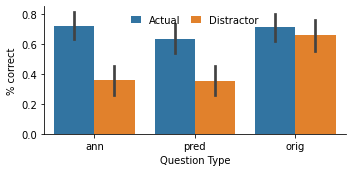

In [30]:
import pathlib
fig, ax = plt.subplots(1,1, figsize=(5,2.5))


sns.barplot(data = df_to_plot, x = "question_type", y = "choice", hue = "is_distractor", ax = ax)
sns.despine()

ax.set_ylabel("% correct")
ax.set_xlabel("Question Type")
handles, labels = ax.get_legend_handles_labels()
labels = ["Actual", "Distractor"]
ax.legend(handles=handles, labels=labels, frameon=False, loc=9, ncol=2, handlelength=1.0, columnspacing=1.0)

plt.tight_layout()
plt.savefig("/Users/Elias/papers/vqa-ambiguity-2022/figures/human_eval.pdf")

## Significance tests
Need to measure the differences for significance. Let's just measure them all pairwise. 


In [37]:
from statsmodels.stats.contingency_tables import mcnemar
def do_mcnemar(choice1, choice2):
    # ----------- table -------------------
    #               ann 1
    #           |-------------|-----------|------------|
    #           |             |  one      |  zero      |
    #           |-------------|-----------|------------|
    # ann 2     |  one        |           |            |
    #           |zero         |           |            |
    #           |-------------|-----------|------------|

    one_one = np.sum(choice1 * choice2)
    one_zero = np.sum(choice1 * (1-choice2))
    zero_one = np.sum((1-choice1)* choice2)
    zero_zero = np.sum((1-choice1) * (1-choice2))


    table_arr = np.zeros((2,2))

    table_arr[0,0] = one_one
    table_arr[1,0] = one_zero
    table_arr[0,1] = zero_one
    table_arr[1,1] = zero_zero

    mac = mcnemar(table_arr, exact=True, correction=False)
    return mac.pvalue, mac.statistic

In [39]:
from itertools import product
import scipy 
is_distractor_choices = [True, False]
question_type_choices = ["ann", "pred", "orig"]

poss_combos = [x for x in product(is_distractor_choices, question_type_choices)]

done = []
for id1, qt1 in poss_combos:
    for id2, qt2 in poss_combos:
        if id1 == id2 and qt1 == qt2: 
            continue
        if id1 != id2 and qt1 != qt2: 
            # don't need to compare across conditions for different question types
            continue
        
        tup = sorted([str(x) for x in [id1, qt1, id2, qt2]])
        if tup in done:
            continue
        done.append(tup)

        d1 = df_to_plot[df_to_plot['is_distractor'] == id1][df_to_plot['question_type'] == qt1]
        d2 = df_to_plot[df_to_plot['is_distractor'] == id2][df_to_plot['question_type'] == qt2]
        d1 = d1['choice'].values
        d2 = d2['choice'].values
        # TODO (elias): once the last assignment is submitted, this can be cut 
        min_len = min(len(d1), len(d2))
        d1 = d1[:min_len]
        d2 = d2[:min_len]
        p_value, stat = do_mcnemar(d1, d2)
        print(f"question_type 1: {qt1}, is_distractor_1: {id1}, question_type 2: {qt2}, is_distractor 2: {id2}, stat: {stat:.2f} p_value: {p_value:.3f}")



question_type 1: ann, is_distractor_1: True, question_type 2: pred, is_distractor 2: True, stat: 17.00 p_value: 1.000
question_type 1: ann, is_distractor_1: True, question_type 2: orig, is_distractor 2: True, stat: 14.00 p_value: 0.000
question_type 1: ann, is_distractor_1: True, question_type 2: ann, is_distractor 2: False, stat: 6.00 p_value: 0.000
question_type 1: pred, is_distractor_1: True, question_type 2: orig, is_distractor 2: True, stat: 12.00 p_value: 0.000
question_type 1: pred, is_distractor_1: True, question_type 2: pred, is_distractor 2: False, stat: 17.00 p_value: 0.000
question_type 1: orig, is_distractor_1: True, question_type 2: orig, is_distractor 2: False, stat: 19.00 p_value: 0.542
question_type 1: ann, is_distractor_1: False, question_type 2: pred, is_distractor 2: False, stat: 20.00 p_value: 0.253
question_type 1: ann, is_distractor_1: False, question_type 2: orig, is_distractor 2: False, stat: 20.00 p_value: 1.000
question_type 1: pred, is_distractor_1: False, q

/var/folders/d2/d0n6tsxs5cq1hbszm2w1sw1m0000gn/T/ipykernel_66982/4008607124.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  d1 = df_to_plot[df_to_plot['is_distractor'] == id1][df_to_plot['question_type'] == qt1]
/var/folders/d2/d0n6tsxs5cq1hbszm2w1sw1m0000gn/T/ipykernel_66982/4008607124.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  d2 = df_to_plot[df_to_plot['is_distractor'] == id2][df_to_plot['question_type'] == qt2]
